/home/hp/anaconda3/envs/openMM/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3101
  warnings.warn(


Hydrogen bond data saved to /home/hp/nayanika/github/GPX6/table/hbond_data.csv
Bar plot saved to /home/hp/nayanika/github/GPX6/figures/hbond_distances.png


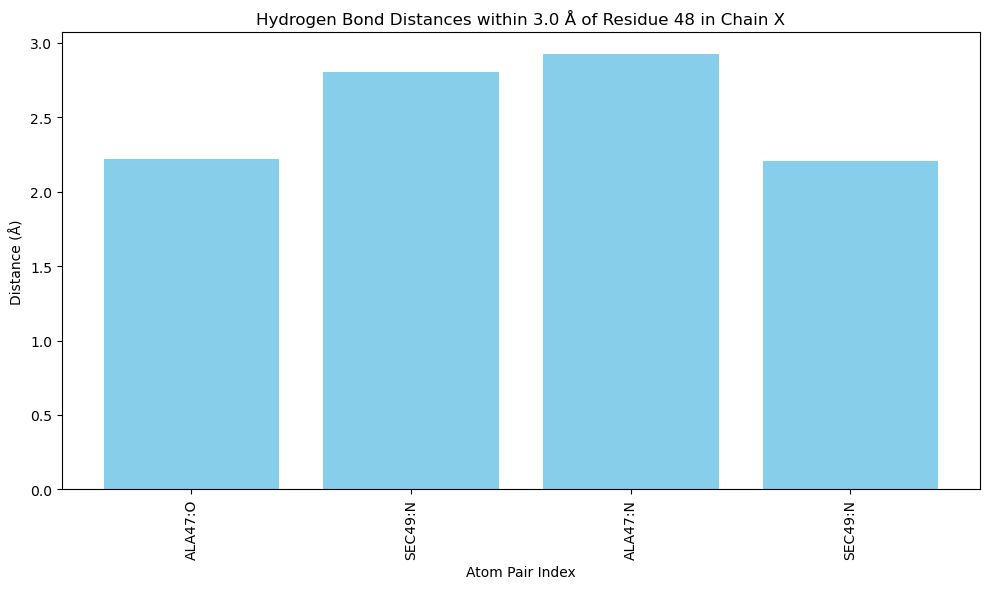

In [6]:
from Bio.PDB import PDBParser, NeighborSearch
import pandas as pd
import matplotlib.pyplot as plt

# Set your parameters
pdb_path = "/home/hp/nayanika/github/GPX6/prep_structures/original_humansec.pdb"  # Replace with your PDB file path
residue_number = 48 # Replace with your target residue number
chain_id = 'X'  # Replace with your chain ID if needed
distance_cutoff = 3.0  # Distance cutoff in Å

# Parse the structure
parser = PDBParser()
structure = parser.get_structure("structure", pdb_path)

# Find the target residue
target_residue = None
for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                if residue.id[1] == residue_number:
                    target_residue = residue
                    break

# Ensure the residue is found
if not target_residue:
    raise ValueError(f"Residue {residue_number} in chain {chain_id} not found.")

# Get all atoms in the structure and search for neighbors
atoms = [atom for atom in structure.get_atoms() if atom.element in ['N', 'O', 'Se', 'S']]
ns = NeighborSearch(atoms)

# Find atoms within the cutoff distance of the target residue
hbond_data = []
for atom in target_residue:
    if atom.element in ['N', 'O', 'Se', 'S']:  # Only consider specific atoms
        close_atoms = ns.search(atom.coord, distance_cutoff)
        for close_atom in close_atoms:
            if close_atom.get_parent() != target_residue:
                hbond_data.append({
                    "Atom1": f"{atom.get_parent().get_resname()}{atom.get_parent().id[1]}:{atom.get_name()}",
                    "Atom2": f"{close_atom.get_parent().get_resname()}{close_atom.get_parent().id[1]}:{close_atom.get_name()}",
                    "Distance (Å)": atom - close_atom
                })

# Convert to DataFrame
df_hbonds = pd.DataFrame(hbond_data)

# Save DataFrame to CSV
output_path = "/home/hp/nayanika/github/GPX6/table/hbond_data.csv"  # Adjust path as needed
df_hbonds.to_csv(output_path, index=False)

# Plotting the distances as a bar plot
plt.figure(figsize=(10, 6))
plt.bar(df_hbonds.index, df_hbonds["Distance (Å)"], color='skyblue')
plt.xlabel("Atom Pair Index")
plt.ylabel("Distance (Å)")
plt.title(f"Hydrogen Bond Distances within {distance_cutoff} Å of Residue {residue_number} in Chain {chain_id}")
plt.xticks(ticks=df_hbonds.index, labels=df_hbonds["Atom2"], rotation=90)
plt.tight_layout()

# Save the plot as an image file
plot_output_path = "/home/hp/nayanika/github/GPX6/figures/hbond_distances.png"
plt.savefig(plot_output_path, dpi=300)

print(f"Hydrogen bond data saved to {output_path}")
print(f"Bar plot saved to {plot_output_path}")
